# Matching Clusters Across Induction and Collection

In [1]:
import sys
sys.path.append('..')

import uproot
import numpy as np
import pandas as pd
import seaborn as sns
import awkward as ak 
import matplotlib.pyplot as plt

from lariat import Event
from matplotlib.patches import Rectangle

In [2]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl") # deuterons from within vertices bounding box + one track protons
print(allclusters.columns); allclusters.shape

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes'],
      dtype='object')


(438575, 27)

In [3]:
# CUTS
print(allclusters.shape)
greaterThanThree = allclusters[allclusters['height'] > 3]; print(greaterThanThree.shape) # Remove all clusters with length = 1, noise
noConstants = greaterThanThree[greaterThanThree['column_maxes'].map(lambda x: len(set(x)) > 1)]; print(noConstants.shape) # Remove all clusters where the max ADC for each wire is the same (no change in energy deposition)

(438575, 27)
(105907, 27)
(105896, 27)


In [4]:
maxes = noConstants['column_maxes'].values

normalised = []

for i, signal in enumerate(maxes):
    
    minimum = 0
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print(f'Error: Max not greater than min in signal {i}.')

    normalised.append(normalised_signal)

noConstants['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; noConstants['maxdiff'] = maxdiff

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_19499/1492737920.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noConstants['normalised'] = normalised
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_19499/1492737920.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_19499/1492737920.py:20: SettingWithCopyWarning: 
A value is trying to

In [5]:
# CUTS
onlyPositiveDiff = noConstants[noConstants['maxdiff'] >= 0].reset_index(drop=True); print(onlyPositiveDiff.shape) # Remove all clusters with only negative change in energy deposition
lessThan180 = onlyPositiveDiff[onlyPositiveDiff['height'] < 180]; print(lessThan180.shape) # Remove all clusters wit length in wire greater than 180 - muons, noise

(105441, 30)
(91658, 30)


In [6]:
collection = (
    (lessThan180['plane'] == 'collection') &
    (lessThan180['max_intensity'] >= 300)
)

# Cuts for induction plane (adjust values as needed)
induction = (
    (lessThan180['plane'] == 'induction') &
    (lessThan180['max_intensity'] >= 150)
)

ADC200cut = lessThan180[collection | induction]; print(ADC200cut.shape) # Remove all clusters with max ADC less than 200, noise

(33527, 30)


In [7]:
# Bounding Box in Each Plane Cuts

collection = (
    (ADC200cut['plane'] == 'collection') &
    (ADC200cut['bbox_min_row'] > 12) & (ADC200cut['bbox_min_row'] < 37) &
    (ADC200cut['bbox_max_col'] > 789) & (ADC200cut['bbox_max_col'] < 1927)
)

# Cuts for induction plane (adjust values as needed)
induction = (
    (ADC200cut['plane'] == 'induction') &
    (ADC200cut['bbox_min_row'] > 11) & (ADC200cut['bbox_min_row'] < 35) &
    (ADC200cut['bbox_max_col'] > 786) & (ADC200cut['bbox_max_col'] < 1794)
)

# Combine both cuts
bboxCut = ADC200cut[collection | induction].reset_index(drop=True); print(bboxCut.shape)

(23523, 30)


In [30]:
bboxCut.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff'],
      dtype='object')

In [8]:
events = bboxCut.groupby(['run', 'subrun', 'event']).size().reset_index(name='count')
event_counts = events['count'].value_counts()
event_counts

count
2    10804
1     1261
3      167
4       37
5        1
Name: count, dtype: int64

In [9]:
grouped = bboxCut.groupby(['run', 'subrun', 'event'])
grouped = grouped.apply(lambda x: x.reset_index(drop=True))
grouped

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_19499/2125964331.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = grouped.apply(lambda x: x.reset_index(drop=True))


event_idx   run  subrun  event  \
run  subrun event                                     
8557 4      473   0        837  8557       4    473   
                  1        837  8557       4    473   
     7      596   0          0  8557       7    596   
                  1          0  8557       7    596   
     9      700   0          1  8557       9    700   
...                        ...   ...     ...    ...   
9788 299    26200 0       3747  9788     299  26200   
            26208 0       7632  9788     299  26208   
     308    26943 0       7634  9788     308  26943   
                  1       7634  9788     308  26943   
     311    27203 0       3941  9788     311  27203   

                                                             file_path  \
run  subrun event                                                        
8557 4      473   0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   
     7      596   0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   
     9      700   0  /Users/user/data/research/proton-deuteron/rawp...   
...                                                                ...   
9788 299    26200 0  /Users/user/data/research/proton-deuteron/rawd...   
            26208 0  /Users/user/data/research/proton-deuteron/rawp...   
     308    26943 0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   
     311    27203 0  /Users/user/data/research/proton-deuteron/rawd...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8557 4      473   0            0      deuteron  collection            0   
                  1            0      deuteron   induction            0   
     7      596   0            0        proton  collection            0   
                  1            0        proton   induction            0   
     9      700   0            0        proton  collection            0   
...                          ...           ...         ...          ...   
9788 299    26200 0            0      deuteron  collection            1   
            26208 0            0        proton   induction            0   
     308    26943 0            0        proton  collection            0   
                  1            0        proton   induction            0   
     311    27203 0            0      deuteron  collection            0   

                       area  ...  width  height  aspect_ratio  compactness  \
run  subrun event            ...                                             
8557 4      473   0   615.0  ...    166       8     20.750000     0.463102   
                  1   334.0  ...    139       5     27.800000     0.480576   
     7      596   0  6161.0  ...    642      93      6.903226     0.103189   
                  1  3352.0  ...    614      94      6.531915     0.058077   
     9      700   0  3880.0  ...    178      57      3.122807     0.382417   
...                     ...  ...    ...     ...           ...          ...   
9788 299    26200 0  1372.0  ...     91      24      3.791667     0.628205   
            26208 0  1456.0  ...    143      52      2.750000     0.195804   
     308    26943 0  2692.0  ...    146      45      3.244444     0.409741   
                  1  1359.0  ...    106      47      2.255319     0.272782   
     311    27203 0  1413.0  ...    128      24      5.333333     0.459961   

                                                       image_intensity  \
run  subrun event                                                        
8557 4      473   0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
     7      596   0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0

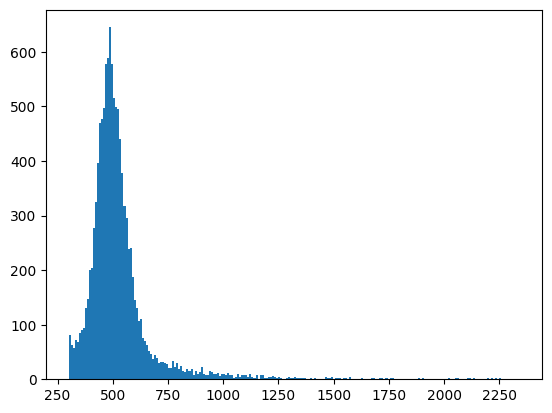

In [10]:
%matplotlib inline
plt.hist(grouped[grouped['plane'] == 'collection']['max_intensity'], bins='auto'); 
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

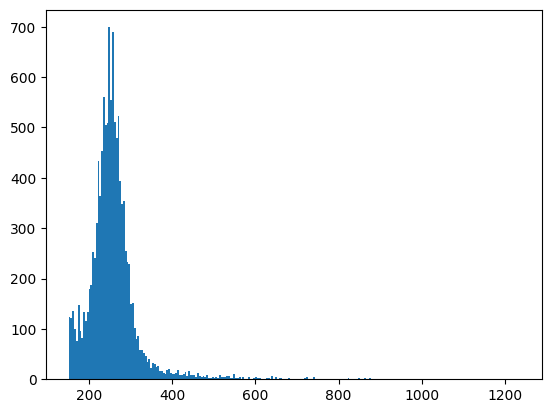

In [11]:
plt.hist(grouped[grouped['plane'] == 'induction']['max_intensity'], bins='auto'); plt.show

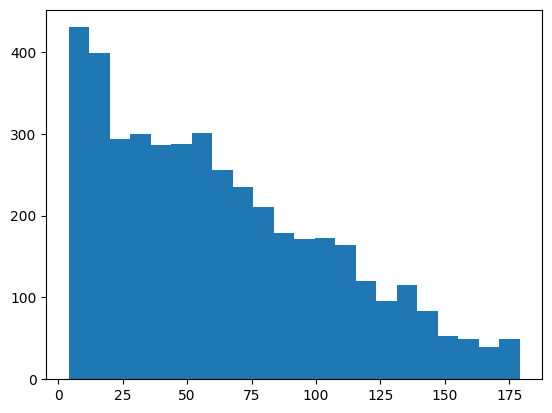

In [31]:
plt.hist(grouped[(grouped['plane'] == 'collection') & (grouped['particle_type'] == 'deuteron')]['height'], bins='auto'); 
plt.show()

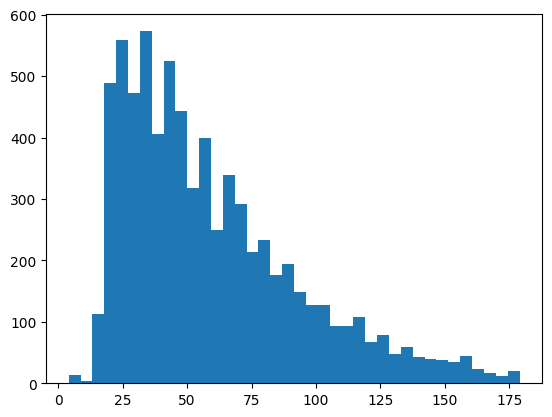

In [32]:
plt.hist(grouped[(grouped['plane'] == 'collection') & (grouped['particle_type'] == 'proton')]['height'], bins='auto'); 
plt.show()

In [12]:
g = grouped.query('run == 8689 and subrun == 92 and event == 8362')
g

event_idx   run  subrun  event  \
run  subrun event                                     
8689 92     8362  0         76  8689      92   8362   
                  1         76  8689      92   8362   

                                                             file_path  \
run  subrun event                                                        
8689 92     8362  0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8689 92     8362  0            0      deuteron  collection            0   
                  1            0      deuteron   induction            0   

                      area  ...  width  height  aspect_ratio  compactness  \
run  subrun event           ...                                             
8689 92     8362  0  834.0  ...    170      12     14.166667     0.408824   
                  1  463.0  ...    123      10     12.300000     0.376423   

                                                       image_intensity  \
run  subrun event                                                        
8689 92     8362  0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                    matrix_transformed  \
run  subrun event                                                        
8689 92     8362  0  [[16.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...   
                  1  [[21.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   

                                                          column_maxes  \
run  subrun event                                                        
8689 92     8362  0  [35.0, 219.0, 317.0, 310.0, 300.0, 291.0, 328....   
                  1  [130.0, 183.0, 185.0, 220.0, 231.0, 217.0, 200...   

                                                            normalised  \
run  subrun event                                                        
8689 92     8362  0  [0.0720164609053498, 0.4506172839506173, 0.652...   
                  1  [0.48872180451127817, 0.6879699248120301, 0.69...   

                                                               adcdiff  \
run  subrun event                                                        
8689 92     8362  0  [0.3786008230452675, 0.2016460905349794, -0.01...   
                  1  [0.19924812030075195, 0.007518796992481147, 0....   

                      maxdiff  
run  subrun event              
8689 92     8362  0  0.378601  
                  1  0.199248  

[2 rows x 30 columns]

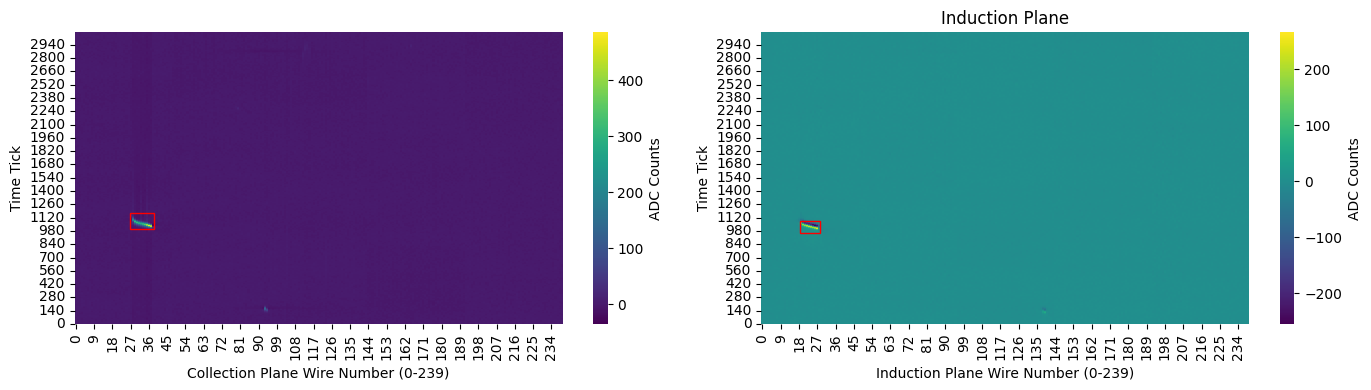

In [13]:
i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
# ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

row = g.iloc[i+1]

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax2.add_patch(rect)

plt.tight_layout()  
# plt.savefig(f'/Users/user/data/research/proton-deuteron/findingdeuterons/{i}.png', 
#             dpi=150, bbox_inches='tight')  
# plt.close()  

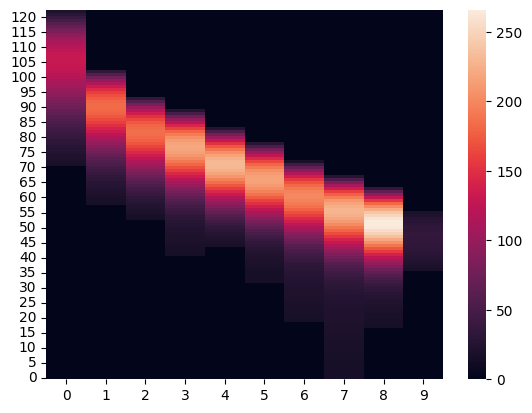

In [14]:
sns.heatmap(row['image_intensity'].T)
plt.gca().invert_yaxis()

In [15]:
c = g.iloc[0]
i = g.iloc[1]

c['max_intensity'], i['max_intensity']

(np.float64(486.0), np.float64(266.0))

In [16]:
print(g['file_path'].iloc[0])

/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008689_sr0092_20160527T090805_evtsel_1.root


In [17]:
event_data = g.copy()


csv_data = pd.DataFrame({
    'run': [event_data['run'].iloc[0]],
    'subrun': [event_data['subrun'].iloc[0]],
    'event': [event_data['event'].iloc[0]],
    'c_w_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_row'].values[0]],
    'c_w_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_row'].values[0]],
    'c_t_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_col'].values[0]],
    'c_t_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_col'].values[0]],
    'i_w_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_row'].values[0]],
    'i_w_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_row'].values[0]],
    'i_t_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_col'].values[0]],
    'i_t_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_col'].values[0]]
})

# Save to a CSV file
csv_data.to_csv('/Users/user/data/research/proton-deuteron/bboxReco.csv', index=False)

# Testing Reco Changes

In [18]:
ROOT = '/Users/user/data/research/proton-deuteron/hist_bbox_100a_RecoBBox100A_20250812T181630.root'

In [19]:
f = uproot.open(ROOT)
f.keys(), f.classnames()

(['hitnumfilter;1',
  'hitnumfilter/NumHits_Ind;1',
  'hitnumfilter/NumHits_Col;1',
  'hitnumfilter/NumHits_Ind_pass;1',
  'hitnumfilter/NumHits_Col_pass;1',
  'hitnumfilter/EventPass;1',
  'timestampfilter;1',
  'timestampfilter/Timestamps;1',
  'timestampfilter/Timestamps_pass;1',
  'timestampfilter/EvtCount;1',
  'tof;1',
  'tof/fderhit;1',
  'tof/fdeltaHit;1',
  'tof/fdeltaHitUS;1',
  'tof/fdeltaHitDS;1',
  'tof/fhitAsymmetryUS;1',
  'tof/fhitAsymmetryDS;1',
  'tof/fLenHit;1',
  'tof/fDerUSA;1',
  'tof/fDerUSB;1',
  'tof/fDerDSA;1',
  'tof/fDerDSB;1',
  'tof/fampHitUSA;1',
  'tof/fampHitUSB;1',
  'tof/fampHitDSA;1',
  'tof/fampHitDSB;1',
  'tof/TOF;1',
  'tof/TimeStamp;1',
  'tof/NTOF;1',
  'gaushitOrigin;1',
  'gaushitOrigin/fFirstChi2;1',
  'gaushitOrigin/fChi2;1',
  'toffilter;1',
  'toffilter/TOFBeforeCut;1',
  'trajcluster;1',
  'trajcluster/showervarstree;1',
  'trajclusterOrigin;1',
  'trajclusterOrigin/showervarstree;1',
  'wcquality;1',
  'wcquality/MomOriginal;1',
  'wcqu

In [20]:
t = f['anatree/anatree;1']
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
subrun               | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
evttime              | double                   | AsDtype('>f8')
efield               | float                    | AsDtype('>f4')
lifetime             | float                    | AsDtype('>f4')
t0                   | int32_t                  | AsDtype('>i4')
nclus                | int32_t                  | AsDtype('>i4')
clustertwire         | float[]                  | AsJagged(AsDtype('>f4'))
clusterttick         | float[]                  | AsJagged(AsDtype('>f4'))
cluendwire           | float[]                  | AsJagged(AsDtype('>f4'))
cluendtick           | float[]                  | AsJagged(AsDtype('>f4'))
cluplane          

In [21]:
data = t.arrays(['run', 'subrun', 'event', 'trkdedx', 'trkrr', 'hit_dEds'], library='pd'); data

,run,subrun,event,trkdedx,trkrr,hit_dEds
0,8689,92,8362,[[[16.12755584716797 17.432693481445312 15.272...,[[[0.23314125835895538 0.6994237899780273 1.16...,[-999.0 3979.763671875 6248.3388671875 10962.3...


In [22]:
a = data['trkdedx'].values.to_numpy()
b = data['trkrr'].values.to_numpy()

i = np.array(a[0][0][0]) # event, track, plane
irr = np.array(b[0][0][0])
c = np.array(a[0][0][1])
crr = np.array(b[0][0][1])

In [23]:
i = i[i != -99999.0]
irr = irr[irr != -99999.0]

c = c[c != -99999.0]
crr = crr[crr != -99999.0]

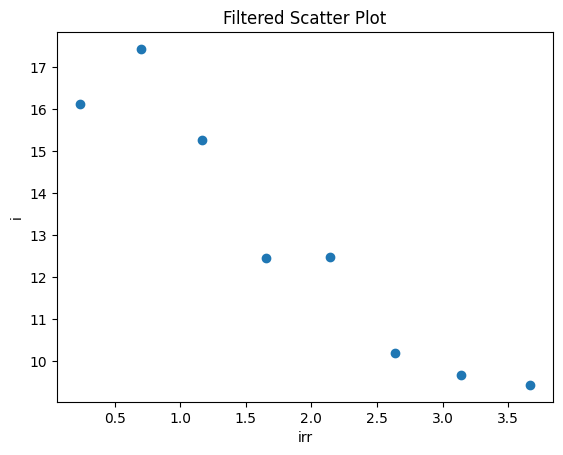

In [24]:
plt.scatter(irr, i)
plt.xlabel("irr")
plt.ylabel("i")
plt.title("Filtered Scatter Plot")
plt.show()

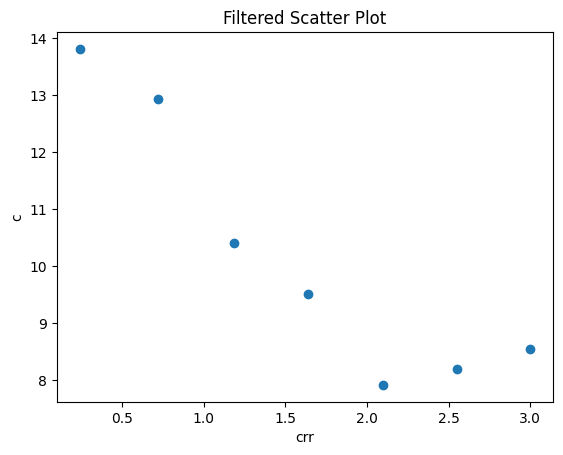

In [25]:
plt.scatter(crr, c)
plt.xlabel("crr")
plt.ylabel("c")
plt.title("Filtered Scatter Plot")
plt.show()

In [26]:
e = data['hit_dEds'].values.to_numpy()
e = np.array(e)

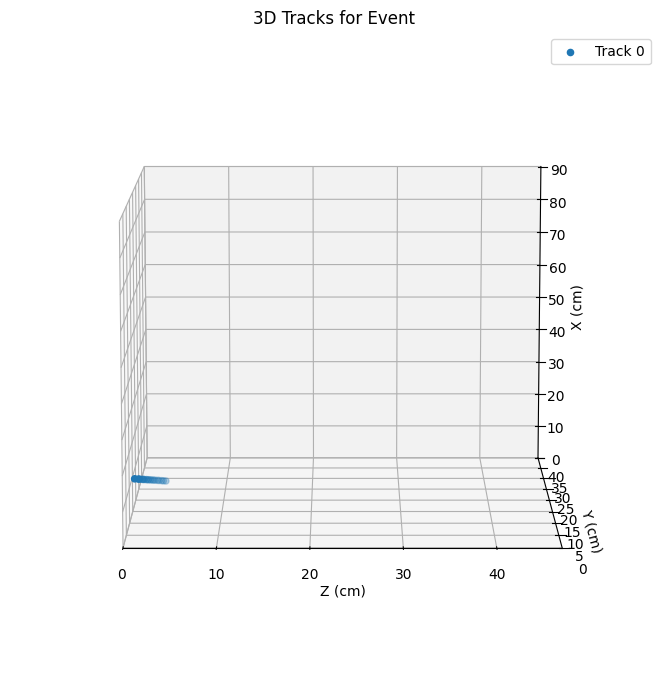

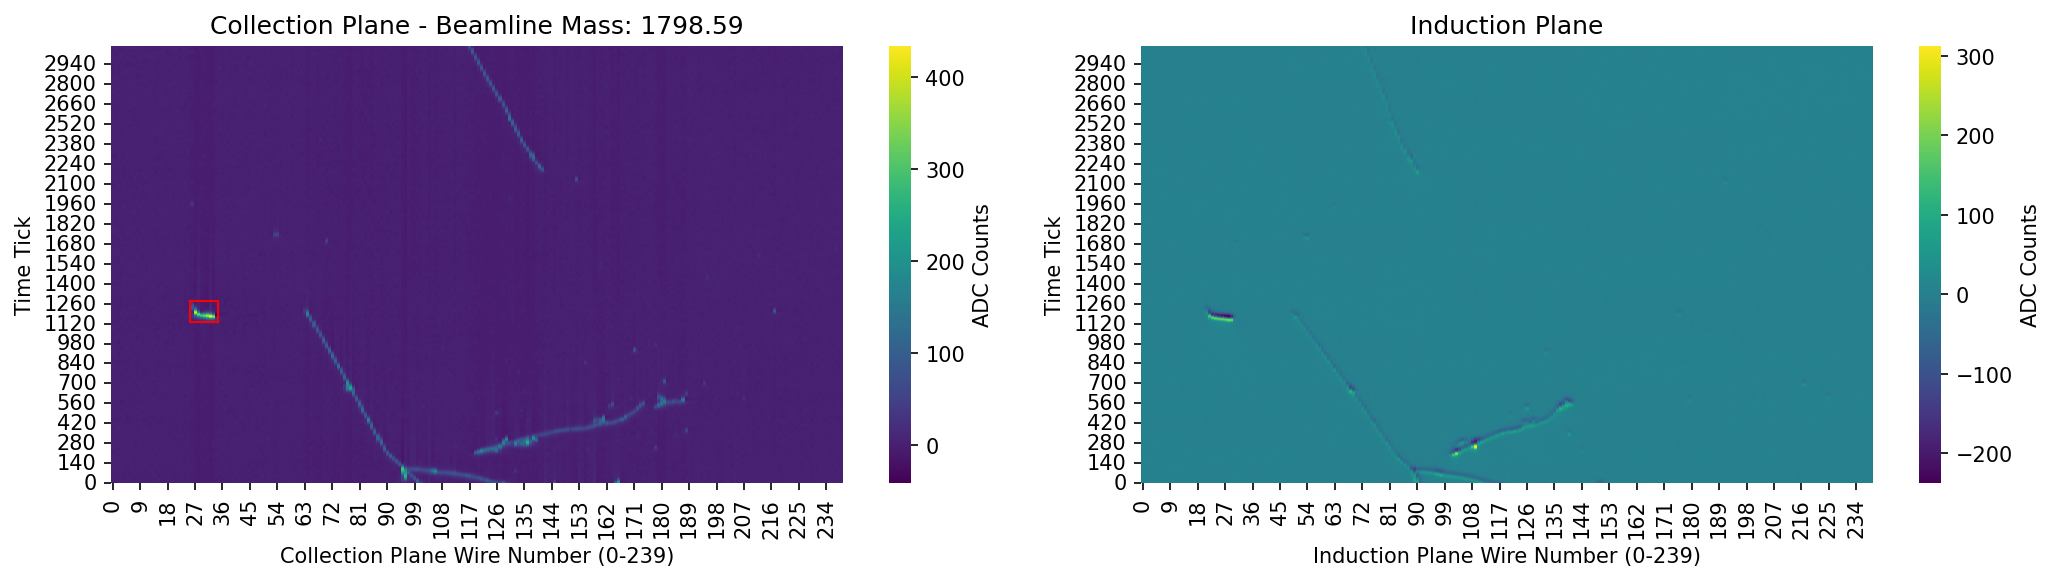

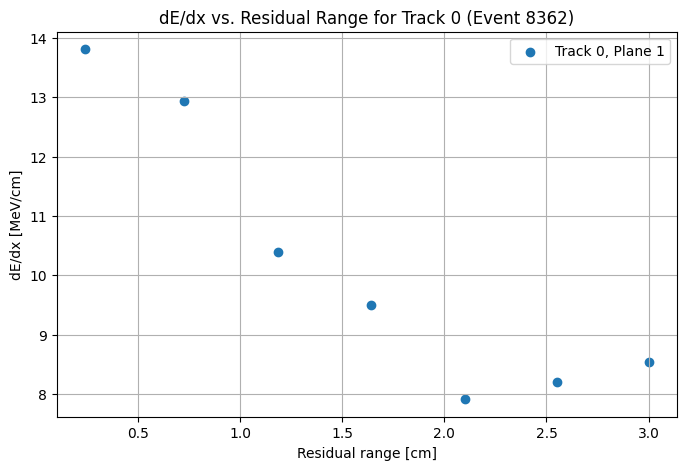

In [28]:
branches = [
    "run", "subrun", "event",

    "nclus", "cluplane",
    "clustertwire", "cluendwire",
    "clusterttick", "cluendtick",
    
    "nhits",
    "hit_plane", "hit_wire", "hit_peakT",
    "hit_trkid",

    "trkdedx", "trkrr", 

    "trkxyz",

    "hit_x", "hit_y", "hit_z",

    "hit_dEds", "hit_resrange"
]

arrays = t.arrays(
    branches,     
    entry_start=0,
    entry_stop=1,
    library     = "ak"
)

# Extract hit data for the event
hit_x = arrays["hit_x"]
hit_y = arrays["hit_y"]
hit_z = arrays["hit_z"]
hit_trkid = arrays["hit_trkid"]

# Get unique track IDs
unique_track_ids = np.unique(hit_trkid)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Iterate over all unique track IDs
for track_id in unique_track_ids:
    if track_id < 0:  # Skip untracked hits
        continue
    
    # Mask hits belonging to the current track
    mask = hit_trkid == track_id
    x = ak.to_numpy(hit_x[mask])
    y = ak.to_numpy(hit_y[mask])
    z = ak.to_numpy(hit_z[mask])
    
    # Plot the track
    ax.scatter(z, y, x, label=f"Track {track_id}")

# Customize the plot
ax.set_xlabel("Z (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("X (cm)")
ax.set_title(f"3D Tracks for Event")
ax.view_init(elev=10, azim=-90)
ax.set_xlim3d(0, 47); ax.set_ylim3d(0, 40); ax.set_zlim3d(0, 90)
ax.legend()
plt.tight_layout()
plt.show()

import os
from PIL import Image
from IPython.display import display

# Extract run, subrun, and event for the current evt_idx
run = int(arrays["run"][0])
subrun = int(arrays["subrun"][0])
event = int(arrays["event"][0])

# Construct the filename
image_folder = "/Users/user/data/research/proton-deuteron/findingdeuterons/"
image_filename = f"48.png"
image_path = os.path.join(image_folder, image_filename)

# Check if the file exists
if os.path.exists(image_path):
    img = Image.open(image_path)
    display(img)
else:
    print(f"Image file not found: {image_path}")

# Get dE/dx and residual range for the first track in plane 1
trk_idx = 0
plane = 1

dEdx = ak.to_numpy(arrays["trkdedx"][0][trk_idx][plane])
rr   = ak.to_numpy(arrays["trkrr"][0][trk_idx][plane])

mask = (dEdx != -99999) & (rr != -99999)
dEdx_clean = dEdx[mask]
rr_clean = rr[mask]

plt.figure(figsize=(8,5))
plt.scatter(rr_clean, dEdx_clean, marker='o', linestyle='-', label=f'Track {trk_idx}, Plane {plane}')
plt.xlabel("Residual range [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title(f"dE/dx vs. Residual Range for Track {trk_idx} (Event {event})")
plt.legend()
plt.grid(True)
plt.show()